In [1]:
import numpy as np
import sqlite3
import os

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers

import albumentations as A


In [16]:
IMAGE_SIZE = (400, 150, 3)
RESIZED_SIZE = (100, 50, 3)
RESIZED_SIZE_PIL = (RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2])

DATASET_PATH = "./data/"
DATASET_PATH = os.path.abspath(DATASET_PATH)
print(DATASET_PATH)

if not os.path.isdir(DATASET_PATH):
    !wget https://fainsil.users.inpt.fr/content/dataset.zip
    !unzip -qq dataset.zip
    !rm dataset.zip

CLASSES = ["octane", "aftershock", "werewolf", "breakout"]
print(CLASSES)

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
EPOCHS = 1
RANDOM_SEED = 2


/tmp/deepl/data
['octane', 'aftershock', 'werewolf', 'breakout']


In [17]:
def view_image(ds):
    images, labels = next(iter(ds)) # extract 1 batch

    plt.figure(figsize=(14, 8))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.title(CLASSES[labels[i]])
        plt.imshow(images[i])

    plt.tight_layout()
    plt.show()

In [18]:
def load_images_from_uuid(uuid, label):
    img = tf.io.read_file(DATASET_PATH + "/" + uuid + ".jpg") # format string doesn't work for some unholy reason -> lost +2 hours on that shit
    img = tf.image.decode_jpeg(img, channels=IMAGE_SIZE[2])
    img = tf.image.resize(img, RESIZED_SIZE_PIL[:-1])
    img = tf.cast(img, "uint8") # required by albumentation
    
    return img, label


In [19]:
def split_dataset(ds, ds_size, train_split=0.7, val_split=0.15, test_split=0.15):
    assert (train_split + test_split + val_split) == 1
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
# get the dataset using SqlDataset
dataset = tf.data.experimental.SqlDataset(
    "sqlite", f"{DATASET_PATH}/index.db", "SELECT uuid, model from data", (tf.string, tf.uint8)
)

# get dataset's length, using sqlite3 since the dataset built by tensorflow has an unknown cardinality
(dataset_length,) = sqlite3.connect(f"{DATASET_PATH}/index.db").execute("SELECT count(uuid) from data").fetchone()

print(dataset_length)

# shuffle the entire dataset, can't shuffle the sqlite query as it is not seedable
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
dataset = dataset.shuffle(dataset_length)

# load images from uuids
dataset = dataset.map(load_images_from_uuid, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# split dataset into training, validation and testing
ds_train, ds_validation, ds_test = split_dataset(dataset, dataset_length)

ds_validation = ds_validation.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(AUTOTUNE)


380870


In [7]:
view_image(ds_train.batch(BATCH_SIZE))

In [21]:
transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        A.Cutout(p=0.5),
    ],
    p=1,
)


def aug_fn(image):
    tf.random.set_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    aug_img = transforms(image=image)["image"]
    return aug_img


def augment_train_dataset(img, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[img], Tout=tf.uint8)
    return aug_img, label


/tmp/deepl/.env/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [25]:
def set_shapes(image, label):
    image.set_shape(RESIZED_SIZE_PIL)
    label.set_shape([])
    
    return image, label


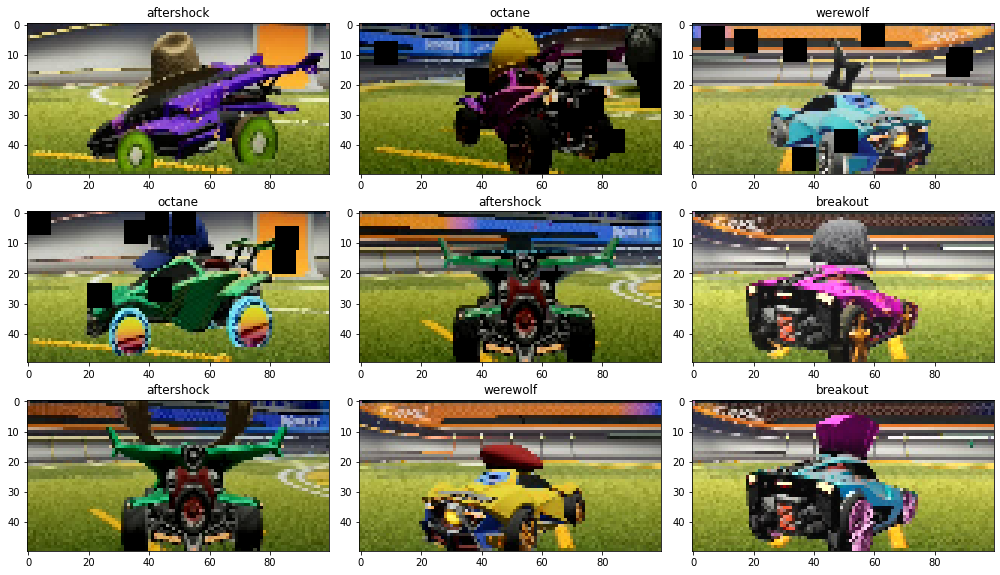

In [26]:
dsa_train = (
    ds_train.map(augment_train_dataset, num_parallel_calls=AUTOTUNE)
    .map(set_shapes, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

view_image(dsa_train)


In [27]:
# build the model
model = Sequential(
    [
        InputLayer(input_shape=RESIZED_SIZE_PIL),
        Conv2D(32, 3, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, 3, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(92, 3, activation="relu", name="conv2d_last"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(250, activation="relu"),
        Dense(4, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 98, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 47, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_last (Conv2D)        (None, 9, 21, 92)         53084     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 10, 92)       

In [ ]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accs = []
        self.val_accs = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('accuracy'))
    
    def on_epoch_end(self, epoch, logs={}):
        self.val_losses.append(logs.get('val_loss'))
        self.val_accs.append(logs.get('val_accuracy'))

In [28]:
# train the model on the dataset
history = LossHistory()
adam = optimizers.Adam(learning_rate=7e-6)
model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(dsa_train, validation_data=ds_validation, epochs=EPOCHS, callbacks=[history])


8332/8332 [==============================] - 2631s 316ms/step - loss: 0.4036 - accuracy: 0.9283 - val_loss: 0.0019 - val_accuracy: 0.9995


In [30]:
# Save the weights
model.save(f"models/full_aug_{EPOCHS}e")


INFO:tensorflow:Assets written to: models/full_aug_1e/assets


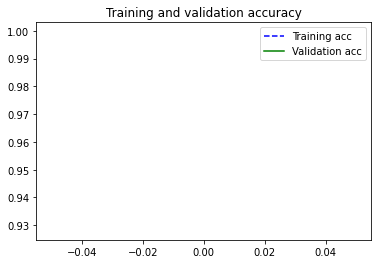

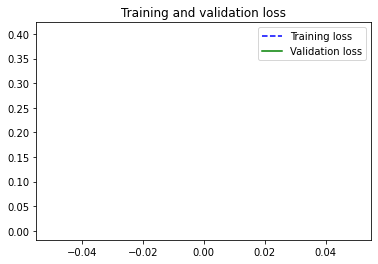

{'loss': [0.4035719037055969],
 'accuracy': [0.9283145070075989],
 'val_loss': [0.0018953183898702264],
 'val_accuracy': [0.9994748830795288]}

In [32]:
def plot_training_analysis():
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(loss))

    plt.plot(epochs, acc, "b", linestyle="--", label="Training acc")
    plt.plot(epochs, val_acc, "g", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, "b", linestyle="--", label="Training loss")
    plt.plot(epochs, val_loss, "g", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    plt.show()


plot_training_analysis()


In [34]:
# création des prédictions sur les données de test
X, Y = ds_test
prediction = model.predict(X)
prediction = np.argmax(prediction, axis=1)
res = tf.math.confusion_matrix(Y, prediction)

# get pandas dataframe
df_cm = pd.DataFrame(res, CLASSES, CLASSES)

# pretty_confusion_matrix
pp_matrix(df_cm, cmap="PuRd")

In [ ]:
def make_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [ ]:
def make_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.004):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    return superimposed_img


In [ ]:
last_conv_layer_name = "C2D_last"
plt.figure(figsize=(15, 18))

for i in range(10):

    img = x_test[i]

    X = np.zeros((1, RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2]))
    X[0] = np.asarray(img)

    # Print what the top predicted class is
    preds = model.predict(X)
    index = np.argmax(preds)

    plt.subplot(10, 5, 5*i+1)
    plt.imshow(img)
    plt.title(f"prediction: {CLASSES[index]}")

    for j in range(4):
        # generate class activation heatmap
        heatmap = make_heatmap(X, model, last_conv_layer_name, pred_index=j)
        # generate gradmap
        gradcam = make_gradcam(img, heatmap)
        
        plt.subplot(10, 5, 5*i+j+2)
        plt.imshow(gradcam)
        plt.title(f"{CLASSES[j]} heatmap")

plt.tight_layout()
plt.show()
